# Deep learning small homework 4

*Name: Fényes Balázs*

*Neptun code: CAU3ZN*

*Email: f.balazs96@gmail.com*

## Downloading the dataset:

I used the [OIDv4 Toolkit](https://github.com/EscVM/OIDv4_ToolKit) to download a subset of the images from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

````
mkdir working_directory
cd working_directory
git clone https://github.com/EscVM/OIDv4_ToolKit.git
cd OIDv4_ToolKit
pip3 install --user -r requirements.txt
python3 main.py downloader --type_csv validation --classes Car --limit 600
python3 main.py downloader --type_csv validation --classes Person --limit 600
````

This will download the images. I then manually moved the first 400 images of each class into the *train* folder, the next 100 into the *validation* folder, the last *100* images into the *test* folder.

The neural network is based on this tutorial: https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069

The VGG16 model is used without the last fully connected layers, because only 2 classes is needed instead of original 1000.

I apply random modifications (brightness change, zoom, ...) to the dataset because of their small number (data augmentation). Then I use these as the input of the VGG network. The output at the last layers (called bottleneck layer by the tutorial) is then saved. This is then used as the input of a fully connected network, whose output is whether the original input was a car or a person.

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, PReLU
from keras import applications, optimizers
from keras.optimizers import RMSprop
from keras import backend as K
import matplotlib.pyplot as plt

# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'khf4_dataset/images/train/'
validation_data_dir = 'khf4_dataset/images/validation/'
test_data_dir = "khf4_dataset/images/test/"
nb_train_samples = 800
nb_validation_samples = 200
nb_test_samples = 200
epochs = 20
batch_size = 10

datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    rotation_range=20, #degrees
    width_shift_range=.15,
    height_shift_range=.15,
    zoom_range=0.2,
    brightness_range=[.8,1.2],
    horizontal_flip=True)

Using TensorFlow backend.


Displaying some of the outputs from the data augmentation process:

Found 800 images belonging to 2 classes.


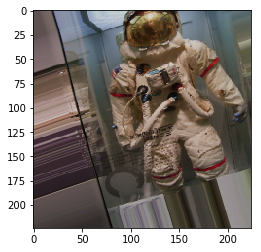

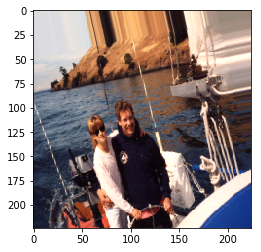

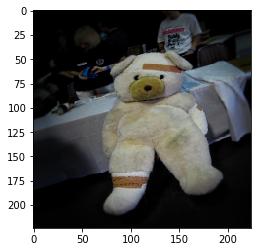

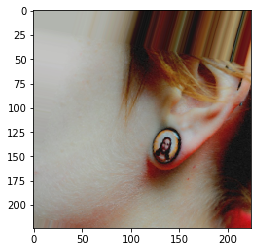

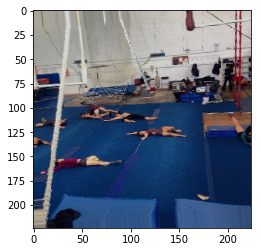

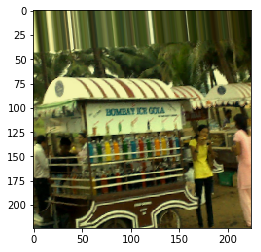

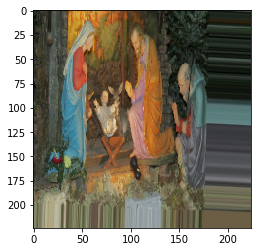

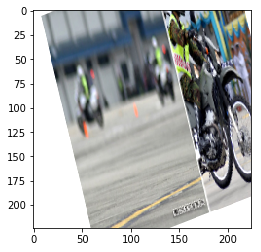

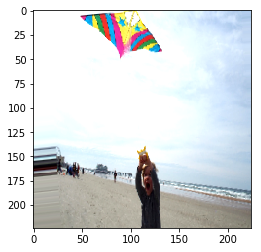

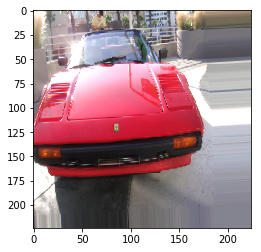

In [2]:
generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=True)
batch = generator.next()
for im in batch:
    plt.figure()
    plt.imshow(im)

Saving the bottleneck features (the activation of the final convolutional layers of the VGG network) for these images:

In [3]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size, verbose=1)
    np.save('bottleneck_features_train.npy',bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size, verbose=1)
    np.save('bottleneck_features_validation.npy',bottleneck_features_validation)

K.clear_session()
save_bottlebeck_features()

Found 800 images belonging to 2 classes.
80/80 [==============================] - 609s 8s/step
Found 200 images belonging to 2 classes.
20/20 [==============================] - 154s 8s/step


Train a fully connected network on the previously saved activations:

The top layers use a high dropout ratio to avoid overfitting.

In [4]:
def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=RMSprop(),loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()

    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose=2)
    model.save_weights(top_model_weights_path)
    return history

K.clear_session()
history = train_top_model()

Train on 800 samples, validate on 200 samples
Epoch 1/20
 - 8s - loss: 2.9624 - acc: 0.7050 - val_loss: 1.0061 - val_acc: 0.8550
Epoch 2/20
 - 7s - loss: 0.8510 - acc: 0.8562 - val_loss: 1.0189 - val_acc: 0.7350
Epoch 3/20
 - 7s - loss: 0.5801 - acc: 0.8562 - val_loss: 0.4123 - val_acc: 0.9150
Epoch 4/20
 - 8s - loss: 0.3697 - acc: 0.9025 - val_loss: 0.6463 - val_acc: 0.9150
Epoch 5/20
 - 8s - loss: 0.3014 - acc: 0.9225 - val_loss: 1.1669 - val_acc: 0.7950
Epoch 6/20
 - 7s - loss: 0.4018 - acc: 0.9200 - val_loss: 0.9159 - val_acc: 0.8550
Epoch 7/20
 - 7s - loss: 0.2794 - acc: 0.9337 - val_loss: 1.0153 - val_acc: 0.8150
Epoch 8/20
 - 7s - loss: 0.2441 - acc: 0.9450 - val_loss: 0.8693 - val_acc: 0.8900
Epoch 9/20
 - 7s - loss: 0.1726 - acc: 0.9537 - val_loss: 0.9716 - val_acc: 0.8900
Epoch 10/20
 - 7s - loss: 0.1695 - acc: 0.9562 - val_loss: 0.8372 - val_acc: 0.9000
Epoch 11/20
 - 7s - loss: 0.1146 - acc: 0.9750 - val_loss: 0.8988 - val_acc: 0.8850
Epoch 12/20
 - 8s - loss: 0.1461 - acc:

Load the VGG16 model without the original fully connected layers and add our pre-trained fully connected network.

Train with the complete VGG16 model:

In [5]:
K.clear_session()
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:19]:
    layer.trainable = False
model.layers[19].trainable=True

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

Model loaded.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/20
80/80 [==============================] - 734s 9s/step - loss: 0.8932 - acc: 0.9062 - val_loss: 0.9732 - val_acc: 0.8950
Epoch 2/20
80/80 [==============================] - 724s 9s/step - loss: 0.8107 - acc: 0.9050 - val_loss: 0.9529 - val_acc: 0.9100
Epoch 3/20
80/80 [==============================] - 722s 9s/step - loss: 0.5562 - acc: 0.9087 - val_loss: 0.6843 - val_acc: 0.9100
Epoch 4/20
80/80 [==============================] - 722s 9s/step - loss: 0.4629 - acc: 0.9312 - val_loss: 0.5471 - val_acc: 0.8900
Epoch 5/20
80/80 [==============================] - 722s 9s/step - loss: 0.3481 - acc: 0.9225 - val_loss: 0.4265 - val_acc: 0.9050
Epoch 6/20
80/80 [==============================] - 722s 9s/step - loss: 0.3261 - acc: 0.9100 - val_loss: 0.3811 - val_acc: 0.9250
Epoch 7/20
80/80 [==============================] - 719s 9s/step - loss: 0.2937 - acc: 0.9212 - val_loss: 0.4192 - val

In [6]:
model.save_weights("vgg16_only_final_layers_trained.h5")

Enable training of the final convolutional layers for fine-tuning the model.

In [7]:
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable=True

model.summary()
i = 0
for l in model.layers:
    print(i,l,"trainable=",l.trainable)
    i += 1
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/osboxes/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Total params: 14,058,305
Trainable params: 6,423,041
Non-trainable params: 7,635,264
_________________________________________________________________
0 <keras.engine.input_layer.InputLayer object at 0x7fece056f198> trainable= False
1 <keras.layers.convolutional.Conv2D object at 0x7fece056f6a0> trainable= False
2 <keras.layers.convolutional.Conv2D object at 0x7fece056f320> trainable= False
3 <keras.layers.pooling.MaxPooling2D object at 0x7fece05152b0> trainable= False
4 <keras.layers.convolutional.Conv2D object at 0x7fece0515908> trainable= False
5 <keras.layers.convolutional.Conv2D object at 0x7fece05397f0> trainable= False
6 <keras.layers.pooling.MaxPooling2D object at 0x7fece04d6160> trainable= False
7 <keras.layers.convolutional.Conv2D object at 0x7fece04d6c50> trainable= False
8 <keras.layers.convolutional.Conv2D object at 0x7fece048e1d0> trainable= False
9 <keras.layers.convolutional.Conv2D object at 0x7fece04ad160> trainable= False
10 <keras.layers.pooling.MaxPooling2D object at

In [8]:
model.save_weights("vgg16_final_conv_layers_trained.h5")

Calculate predictions with the trained model on the test dataset (displaying 5-5 images from each category). The predictions are very accurate, but a few images have cars AND people in it, where it may not choose that category which the image originally belonged to.

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
5/5 [==============================] - 5s 904ms/step
[[2.90705287e-03]
 [1.13484406e-04]
 [1.20209688e-02]
 [4.65471061e-07]
 [1.07003574e-03]]
5/5 [==============================] - 3s 563ms/step
[[1.        ]
 [0.99980706]
 [1.        ]
 [0.9649433 ]
 [0.9999857 ]]


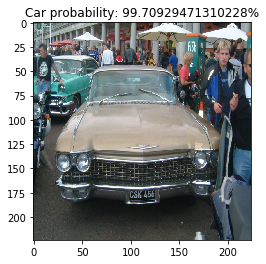

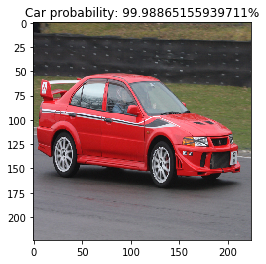

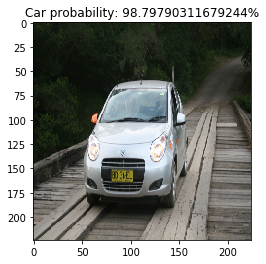

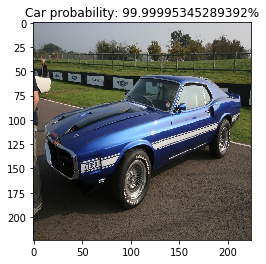

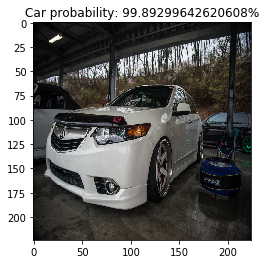

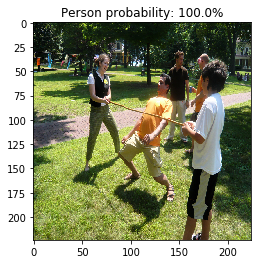

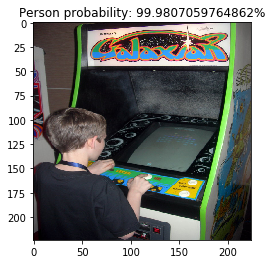

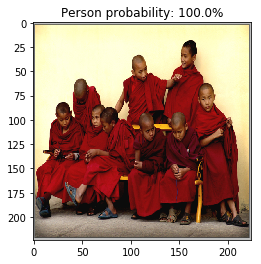

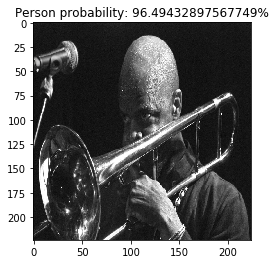

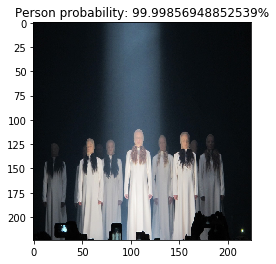

In [9]:
datagen_test = ImageDataGenerator(rescale=1. / 255)

generator_test_car = datagen_test.flow_from_directory(
        test_data_dir,
        classes=["car"],
        target_size=(img_width, img_height),
        batch_size=5,
        class_mode=None,
        shuffle=True)

generator_test_person = datagen_test.flow_from_directory(
        test_data_dir,
        classes=["person"],
        target_size=(img_width, img_height),
        batch_size=5,
        class_mode=None,
        shuffle=True)

test_car = generator_test_car.next()
test_person = generator_test_person.next()

predictions_car = model.predict(test_car, verbose=1)
print(predictions_car)
predictions_person = model.predict(test_person, verbose=1)
print(predictions_person)

i = 0
for im in test_car:
    plt.figure()
    plt.imshow(im)
    plt.title("Car probability: " + str(100-predictions_car[i][0]*100) + "%")
    i += 1

i = 0
for im in test_person:
    plt.figure()
    plt.imshow(im)
    plt.title("Person probability: " + str(predictions_person[i][0]*100) + "%")
    i += 1

In [10]:
all_car_preds = model.predict_generator(generator_test_car, verbose=1)
print(all_car_preds)
all_person_preds = model.predict_generator(generator_test_person, verbose=1)
print(all_person_preds)


print("Accuracy on test:", (sum(map(lambda i: i < .5, all_car_preds))+sum(map(lambda i: i >= .5, all_person_preds)))/200)

20/20 [==============================] - 72s 4s/step
[[2.90705287e-03]
 [1.13484406e-04]
 [1.20209688e-02]
 [4.65471061e-07]
 [1.07003574e-03]
 [4.69350925e-06]
 [1.32181303e-04]
 [7.74354616e-04]
 [2.18882374e-02]
 [1.07087404e-03]
 [5.31735655e-04]
 [4.31661523e-04]
 [7.47507220e-05]
 [2.52462196e-04]
 [7.93907238e-05]
 [9.70203757e-01]
 [2.05025673e-04]
 [1.24076405e-03]
 [8.64265021e-03]
 [4.44807782e-04]
 [1.79239325e-02]
 [2.97662336e-04]
 [1.32353845e-04]
 [9.20097250e-03]
 [2.08859342e-06]
 [3.32475320e-05]
 [3.26960260e-04]
 [1.45655897e-04]
 [6.98412279e-08]
 [1.59303017e-04]
 [1.48576955e-05]
 [1.32637411e-01]
 [2.64037371e-04]
 [6.02748133e-02]
 [9.99868870e-01]
 [3.56695760e-04]
 [8.68458953e-03]
 [1.97695829e-02]
 [4.17505112e-03]
 [5.30281568e-06]
 [1.79892260e-04]
 [7.20871612e-02]
 [3.87352047e-04]
 [6.97595775e-02]
 [9.53785730e-06]
 [3.56513510e-07]
 [4.37784707e-03]
 [3.04679922e-03]
 [1.48793784e-04]
 [1.75275200e-03]
 [9.24289168e-04]
 [4.62727505e-04]
 [1.0766320